Required packets

In [22]:
from pandas import read_csv, Timedelta
import torch
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt

## Peek Detection

Load the transform and retrive the right threshold based on the scale, need to understand how to deal with trend probably must be sum

In [23]:
series = read_csv('coefficents.csv', header = 0, index_col = 0, parse_dates= True)
series_or = read_csv('series_normalized.csv', header = 0, index_col = 0, parse_dates= True)


# Initialize lists to store coefficients and heights
wav_coef = []
height = []
time_index = series.index
time_diff = time_index.to_series().diff().min()
dim = series.shape[0]


# To decide the threshold based on the sampling frequency
daily_threshold = Timedelta(days=1)
weekly_threshold = Timedelta(weeks=1)
monthly_threshold = Timedelta(days=28)
series_or = series_or.values.flatten()
top_10_values = np.sort(series_or)[-20:]
best_or = np.mean(top_10_values)
median = np.median(np.sort(series_or))
best_or = best_or + np.abs(median)
print("Best height: ", best_or)

print(time_diff)

if time_diff < daily_threshold:
  time_diff = 0
  final_result = torch.zeros(dim, 4)
  # Iterate over each column in the DataFrame
  for column in series.columns:
      
      # Get the values of the current column
      coef = series[column].values

      # Append the coefficients to the list
      wav_coef.append(coef)
      
      # Find the best height for the current column
      top_10_values = np.sort(coef)[-10:]
      best_height = np.mean(top_10_values)
      threshold = best_height * 0.45
      
      
      # Determine the height based on the column name or any other criteria
      if 'daily' in column.lower():
          threshold_def = np.abs(best_or*1)
          if threshold > threshold_def:
              height.append(threshold)
          else:
              height.append(threshold_def)
      elif 'weekly' in column.lower():
          threshold_def = np.abs(best_or*2)
          if threshold > threshold_def:
              height.append(threshold)
          else:
              height.append(threshold_def)
      elif 'monthly' in column.lower():
          threshold_def = np.abs(best_or*4)
          if threshold > threshold_def:
              height.append(threshold)
          else:
              height.append(threshold_def)
      elif 'yearly' in column.lower():
          threshold_def = np.abs(best_or*15)
          if threshold > threshold_def:
              height.append(threshold)
          else:
              height.append(threshold_def)
      else:
          # Handle other cases as needed
          raise ValueError("Unsupported Frequency")
elif time_diff == daily_threshold:
  time_diff = 1
  final_result = torch.zeros(dim, 3)
  # Iterate over each column in the DataFrame
  for column in series.columns:
      # Get the values of the current column
      coef = series[column].values

      # Append the coefficients to the list
      wav_coef.append(coef)
      
      # Find the best height for the current column
      top_10_values = np.sort(coef)[-10:]
      best_height = np.mean(top_10_values)
      threshold = best_height * 0.45

      # Determine the height based on the column name or any other criteria
      if 'weekly' in column.lower():
          threshold_def = np.abs(best_or*0.5)
          if threshold > threshold_def:
              height.append(threshold)
          else:    
              height.append(threshold_def)
      elif 'monthly' in column.lower():
          threshold_def = np.abs(best_or*1)
          if threshold > threshold_def:
              height.append(threshold)
          else:
              height.append(threshold_def)
      elif 'yearly' in column.lower():
          threshold_def = np.abs(best_or*2)
          if threshold > 2:
              height.append(threshold)
          else:
              height.append(2)
      else:
          # Handle other cases as needed
          raise ValueError("Unsupported Frequency")
elif time_diff == weekly_threshold:
  time_diff = 2
  final_result = torch.zeros(dim, 2)
  # Iterate over each column in the DataFrame
  for column in series.columns:
      # Get the values of the current column
      coef = series[column].values

      # Append the coefficients to the list
      wav_coef.append(coef)
      
      # Find the best height for the current column
      top_10_values = np.sort(coef)[-10:]
      best_height = np.mean(top_10_values)
      threshold = best_height * 0.45
        
      if 'monthly' in column.lower():
          threshold_def = np.abs(best_or*0.5)
          if threshold > threshold_def:
              height.append(threshold)
          else:
              height.append(threshold_def)
      elif 'yearly' in column.lower():
          threshold_def = np.abs(best_or*1)
          if threshold > threshold_def:
              height.append(threshold)
          else:
              height.append(threshold_def)
      else:
          # Handle other cases as needed
          raise ValueError("Unsupported Frequency")
elif time_diff == monthly_threshold:
  time_diff = 3
  final_result = torch.zeros(dim, 1)
  # Iterate over each column in the DataFrame
  for column in series.columns:
    # Get the values of the current column
    coef = series[column].values

    # Append the coefficients to the list
    wav_coef.append(coef)
    
    # Find the best height for the current column
    top_10_values = np.sort(coef)[-10:]
    best_height = np.mean(top_10_values)
    threshold = best_height * 0.45
    print(threshold)
    if 'yearly' in column.lower():
        
        threshold_def = np.abs(best_or*0.5)
        print(threshold_def)
        if threshold > threshold_def:
            height.append(threshold)
        else:
            height.append(threshold_def)
    else:
        # Handle other cases as needed
        raise ValueError("Unsupported Frequency")
print(height)


Best height:  1.0297064969575795
28 days 00:00:00
0.29953604699999997
0.5148532484787898
[0.5148532484787898]


Find the index for each scale of those part with a match higher then the threshold

len coef: 864, end_index: 860


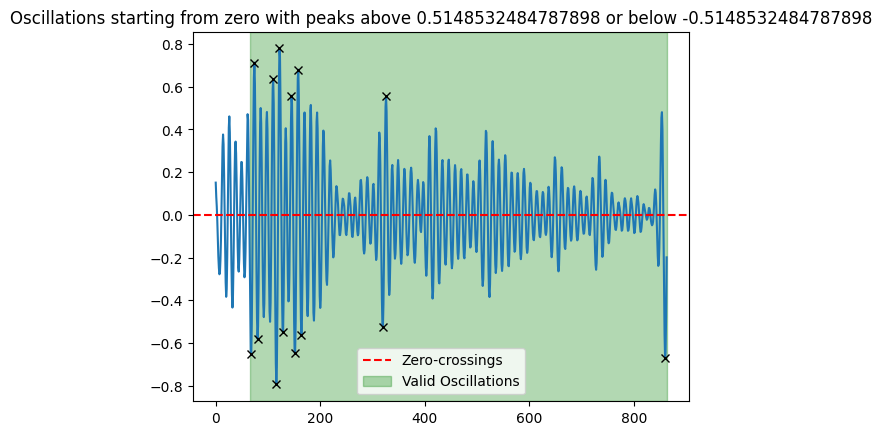

Indices of all oscillations: [65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 857, 858, 859, 860, 861, 862, 863]
[ 65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100
 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156 157 158 159 160 161 162 163 164 165 166 167 168]
torch.Size([864, 1])


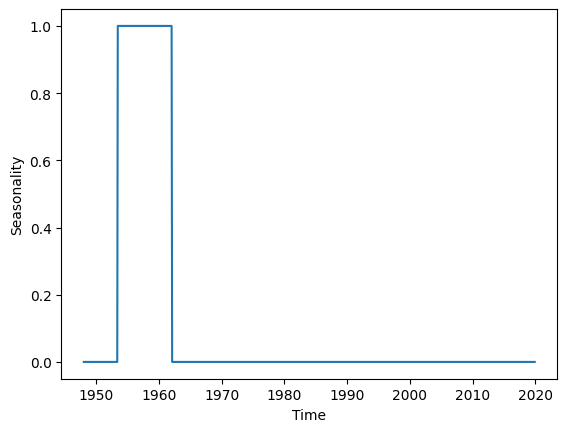

In [24]:
iter = 0


for height, coef in zip(height, wav_coef):
  iter = iter + 1
  # Assuming coef is your ndarray
  peaks_above, _ = find_peaks(coef, height)
  peaks_below, _ = find_peaks(-coef, height)
  # Combine the peaks from both conditions
  all_peaks = np.concatenate([peaks_above, peaks_below])
  # Sort the indices for plotting purposes
  all_peaks = np.sort(all_peaks)

  # Find zero-crossings by detecting sign changes
  coefsign = np.sign(coef)
  signchange = ((np.roll(coefsign, 1) - coefsign) != 0).astype(int)
  zero_crossings = np.where(signchange == 1)[0]

  # Initialize an array to store indices of all oscillations
  all_oscillations = []

  if all_peaks.size == 0:
    print(f'All points under {height}')
    continue

  if all_peaks[0] < zero_crossings[0]:
    i = zero_crossings[0]
    all_oscillations.extend(range(0, i))

  # Iterate through zero-crossings to identify entire oscillations
  for i in range(len(zero_crossings) - 1):
      start_index = zero_crossings[i]
      end_index = zero_crossings[i + 1]

      # Check if there are peaks above the threshold within the interval
      if np.max(coef[start_index:end_index]) > height or np.min(coef[start_index:end_index]) < -height:
          all_oscillations.extend(range(start_index, end_index + 1))



  # Check if the last peak is above the threshold
  if all_peaks[-1] > zero_crossings[-1]:
      start_index = zero_crossings[-1]
      end_index = all_peaks[-1]


      # Extend the oscillation to the right if values are increasing
      print (f"len coef: {len(coef)}, end_index: {end_index}")
      while end_index < len(coef) - 1 and abs(coef[end_index]) > abs(coef[end_index + 1]):
          end_index += 1

      all_oscillations.extend(range(start_index, end_index + 1))

  # Select unique indexes
  all_oscillations = np.unique(all_oscillations).tolist()

  # Plotting
  plt.plot(coef)
  plt.plot(all_peaks, coef[all_peaks], "xk")
  plt.axhline(y=0, color='r', linestyle='--', label='Zero-crossings')
  plt.axvspan(all_oscillations[0], all_oscillations[-1], color='green', alpha=0.3, label='Valid Oscillations')
  plt.title(f'Oscillations starting from zero with peaks above {height} or below {-height}')
  plt.legend()
  plt.show()

  # Print the array of all oscillations indices
  print("Indices of all oscillations:", all_oscillations)

  # Check for consecutive index
  for i in range(len(all_oscillations)-1):
    if all_oscillations[i]+1 != all_oscillations[i+1]:
      count = all_oscillations[i+1]-all_oscillations[i]
      if time_diff == 0:
        if iter == 1 and count <= 48:
          all_oscillations.extend(range(all_oscillations[i], all_oscillations[i+1]))
        elif iter == 2 and count <= 2*24*7:
          all_oscillations.extend(range(all_oscillations[i], all_oscillations[i+1]))
        elif iter == 3 and count <= 2*24*28:
          all_oscillations.extend(range(all_oscillations[i], all_oscillations[i+1]))
        elif iter == 4 and count <= 2*24*360:
          all_oscillations.extend(range(all_oscillations[i], all_oscillations[i+1]))
      elif time_diff == 1:
        if iter == 1 and count <= 2*7:
          all_oscillations.extend(range(all_oscillations[i], all_oscillations[i+1]))
        elif iter == 2 and count <= 2*28:
          all_oscillations.extend(range(all_oscillations[i], all_oscillations[i+1]))
        elif iter == 3 and count <= 2*360:
          all_oscillations.extend(range(all_oscillations[i], all_oscillations[i+1]))
      elif time_diff == 2:
        if iter == 1 and count <= 2*4:
          all_oscillations.extend(range(all_oscillations[i], all_oscillations[i+1]))
        elif iter == 2 and count <= 2*4*12:
          all_oscillations.extend(range(all_oscillations[i], all_oscillations[i+1]))
      elif time_diff == 3:
        if count <= 2*12:
          all_oscillations.extend(range(all_oscillations[i], all_oscillations[i+1]))

  all_oscillations = np.unique(all_oscillations)
  non_consecutive_indices = []
  
  # Check for consecutive index
  i = 0
  while i < len(all_oscillations) - 1:
      start_index = all_oscillations[i]
      end_index = all_oscillations[i]
      
      # Find the end of the consecutive sequence
      while i < len(all_oscillations) - 1 and all_oscillations[i] + 1 == all_oscillations[i+1]:
          end_index = all_oscillations[i+1]
          i += 1

      # Check if the consecutive sequence is shorter than the count
      count = end_index - start_index + 1
      
      if time_diff == 0 and iter == 1 and count <= 48:
          non_consecutive_indices.extend(range(start_index, end_index + 1))
      elif time_diff == 1 and iter == 1 and count <= 14:
          non_consecutive_indices.extend(range(start_index, end_index + 1))
      elif time_diff == 1 and iter == 2 and count <= 56:
          non_consecutive_indices.extend(range(start_index, end_index + 1))
      elif time_diff == 1 and iter == 3 and count <= 720:
          non_consecutive_indices.extend(range(start_index, end_index + 1))
      elif time_diff == 2 and iter == 1 and count <= 8:
          non_consecutive_indices.extend(range(start_index, end_index + 1))
      elif time_diff == 2 and iter == 2 and count <= 8*12:
          non_consecutive_indices.extend(range(start_index, end_index + 1))
      elif time_diff == 3 and count <= 24:
          non_consecutive_indices.extend(range(start_index, end_index + 1))

      i += 1

  # Remove consecutive indices shorter than the count threshold from all_oscillations
  all_oscillations = np.array([index for index in all_oscillations if index not in non_consecutive_indices])

  i=0

  for i in range(len(all_oscillations)-1):
    if all_oscillations[i]+1 != all_oscillations[i+1]:
      print(f"No consecutive index {all_oscillations[i]}-{all_oscillations[i+1]}")

  print(all_oscillations)

  # Itera su ogni indice in all_oscillations
  for idx in all_oscillations:
    # Aggiorna il valore nella riga corrispondente del tensore final_result
    final_result[idx, iter-1] = 1


  print(final_result.shape)
  torch.save(final_result, 'result.pt')
# Plot
for i in range(final_result.shape[1]):
  plt.plot(time_index, final_result[:,i])
  plt.xlabel('Time')
  plt.ylabel('Seasonality')
  plt.show()